# Load Dependencies

In [188]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

# Define Paths to Files

In [189]:
BAD_FILE = os.path.join("C:/Users/jreye/AudioAudio/Bad/fuck1.wav") # path to single file
NOT_BAD_FILE = os.path.join("C:/Users/jreye/Documents/GoogleSpeech_V2/TRAINING_1/happy (1).wav")

# Build Dataloading Function

In [190]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

# Plot Wave

In [191]:
wave = load_wav_16k_mono(BAD_FILE) # load data to plot wave
nwave = load_wav_16k_mono(NOT_BAD_FILE)

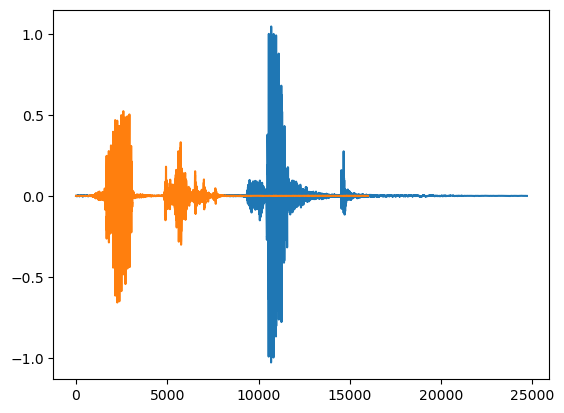

In [192]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# Create TensorFlow Dataset

In [193]:
# define paths to positive and negative data
BAD = os.path.join("C:/Users/jreye/AudioAudio/Bad") 
NOT_BAD = os.path.join("C:/Users/jreye/Documents/GoogleSpeech_V2/TRAINING_1")

In [194]:
BAD

'C:/Users/jreye/AudioAudio/Bad'

In [195]:
# create TensorFlow datasets
pos = tf.data.Dataset.list_files(BAD+'\*.wav') 
neg = tf.data.Dataset.list_files(NOT_BAD+'\*.wav')

In [196]:
pos.as_numpy_iterator().next()

b'C:\\Users\\jreye\\AudioAudio\\Bad\\Recording #40.wav'

In [197]:
# add labels and combine positive and negative samples
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(pos)))))
data = positives.concatenate(negatives)

In [198]:
positives.as_numpy_iterator().next()

(b'C:\\Users\\jreye\\AudioAudio\\Bad\\Recording #31.wav', 1.0)

In [199]:
data.shuffle(10000).as_numpy_iterator().next()

(b'C:\\Users\\jreye\\Documents\\GoogleSpeech_V2\\TRAINING_1\\up(52).wav', 0.0)

# Determine Average Length of a Spoken Word

In [200]:
# calculate wave cycle length
lengths = []
for file in os.listdir(os.path.join("C:/Users/jreye/AudioAudio/Bad")):
    tensor_wave = load_wav_16k_mono(os.path.join("C:/Users/jreye/AudioAudio/Bad", file))
    lengths.append(len(tensor_wave))

In [201]:
# list files in bad words directory
os.listdir(os.path.join("C:/Users/jreye/AudioAudio/Bad")) 

['fuck1.wav',
 'fuck2.wav',
 'fuck3.wav',
 'fuck4.wav',
 'fuck5.wav',
 'fuck6.wav',
 'Recording #18.wav',
 'Recording #19.wav',
 'Recording #20.wav',
 'Recording #21.wav',
 'Recording #22.wav',
 'Recording #23.wav',
 'Recording #24.wav',
 'Recording #25.wav',
 'Recording #26.wav',
 'Recording #27.wav',
 'Recording #28.wav',
 'Recording #29.wav',
 'Recording #30.wav',
 'Recording #31.wav',
 'Recording #32.wav',
 'Recording #33.wav',
 'Recording #34.wav',
 'Recording #35.wav',
 'Recording #36.wav',
 'Recording #37.wav',
 'Recording #38.wav',
 'Recording #39.wav',
 'Recording #40.wav',
 'Recording #41.wav',
 'Recording #42.wav',
 'Recording #43.wav']

In [202]:
# length of each wav file
lengths

[24706,
 28049,
 29266,
 31764,
 16532,
 21548,
 13003,
 20805,
 20805,
 14303,
 14303,
 29907,
 14303,
 20805,
 24706,
 18204,
 15603,
 11702,
 15603,
 14303,
 22105,
 15603,
 14303,
 18204,
 22105,
 19504,
 22105,
 29907,
 29907,
 31207,
 22105,
 23405]

In [203]:
# calculate mean
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=20958>

In [204]:
# calculate min
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=11702>

In [205]:
# calculate max
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=31764>

In [206]:
# ave length of bad word
tf.math.reduce_mean(lengths)/16000

<tf.Tensor: shape=(), dtype=float64, numpy=1.309875>

In [207]:
# min length of bad word
tf.math.reduce_min(lengths)/16000

<tf.Tensor: shape=(), dtype=float64, numpy=0.731375>

In [208]:
# max length of bad word
tf.math.reduce_max(lengths)/16000

<tf.Tensor: shape=(), dtype=float64, numpy=1.98525>

# Build Preprocessing Function to Convert to Spectrogram

In [209]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:25000] # 25000 sample length (can make smaller to reduce processing time but will affect accuracy)
    zero_padding = tf.zeros([25000] - tf.shape(wav), dtype=tf.float32) 
    wav = tf.concat([zero_padding, wav],0) # pad clips longer than 25000 samples wiht zeros
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

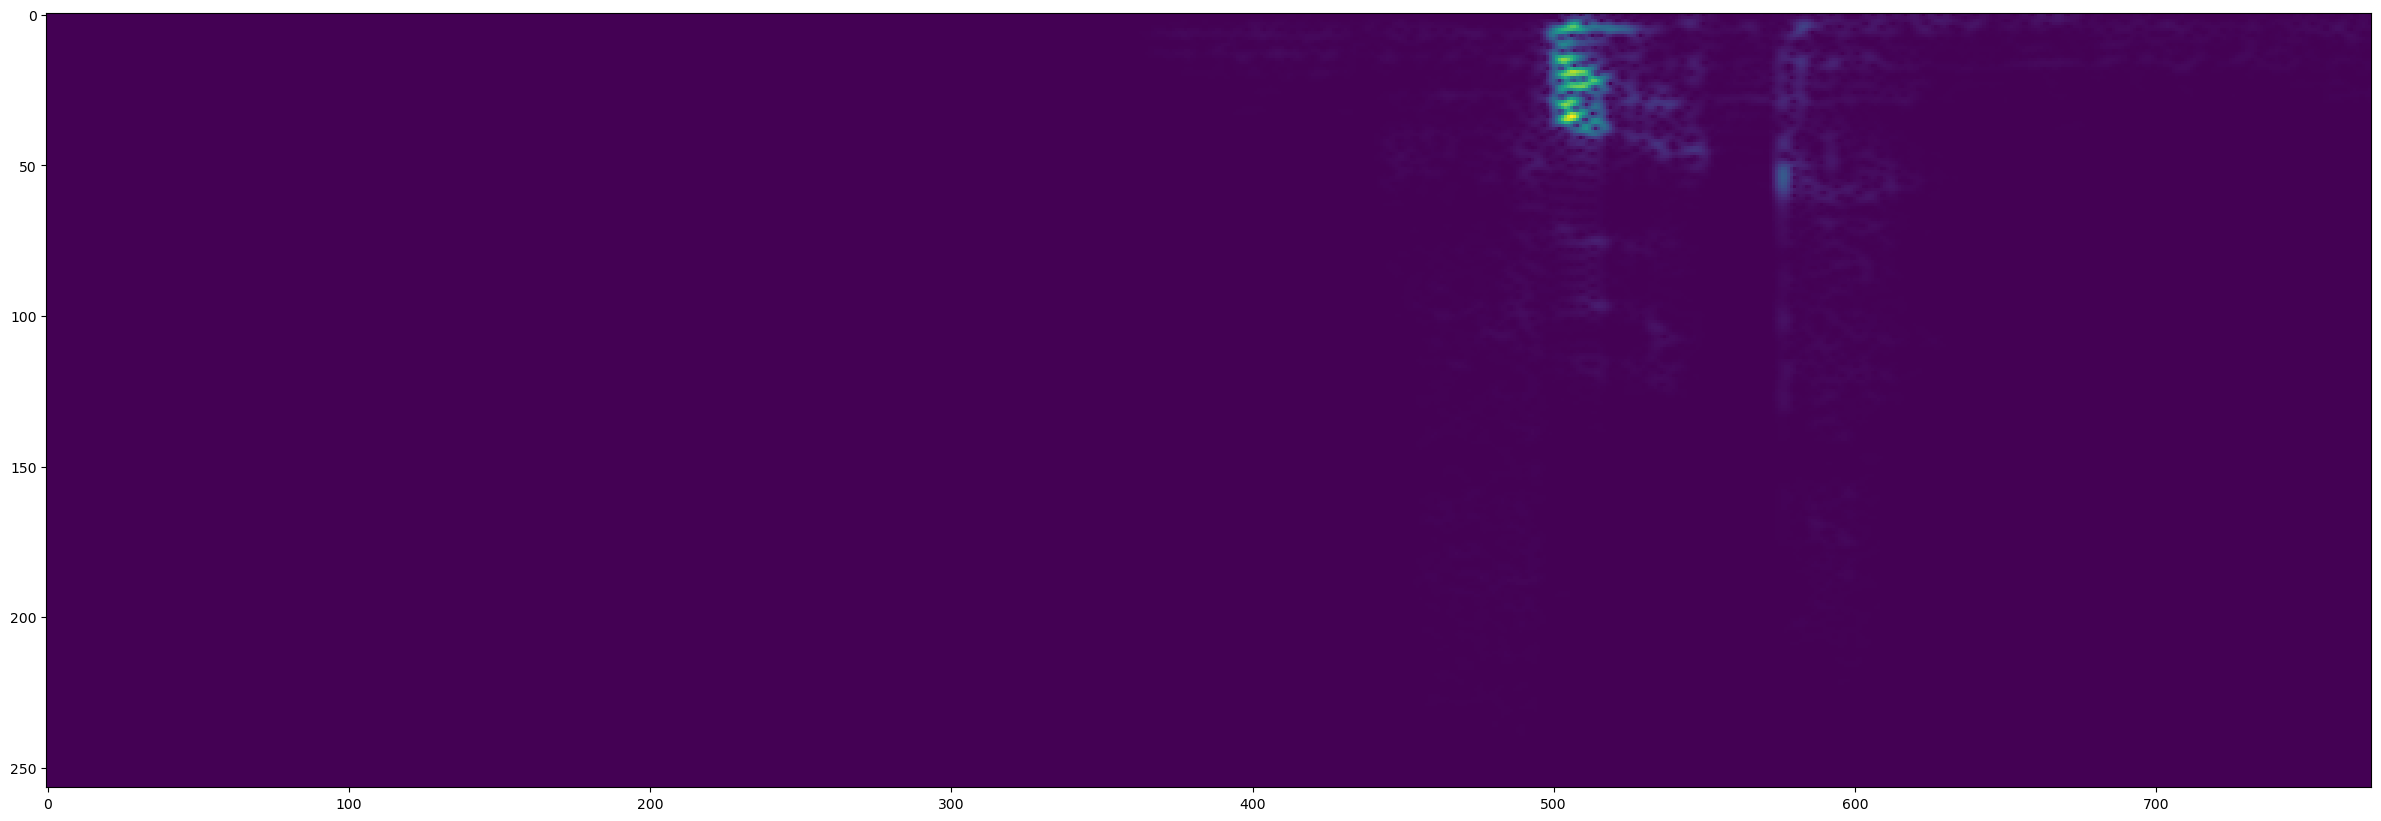

In [210]:
# test out the function and visualize the spectrogram (bad words)
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# Create Training and Testing Partitions

In [211]:
len(data)

64

In [212]:
# create TensorFlow data pipeline
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(4)
data = data.prefetch(2)

In [216]:
len(data)

16

In [217]:
# split into training and testing partitions
train = data.take(11)
test = data.skip(11).take(5)

In [218]:
# test one batch
samples, labels = train.as_numpy_iterator().next()

In [219]:
samples.shape

(4, 772, 257, 1)

In [221]:
labels

array([1., 0., 1., 0.], dtype=float32)

# Build Deep Learning Model

In [222]:
# load Keras Model dependencies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [224]:
# build sequential model, compile, and view summary
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(772, 257, 1))) # input shape depends on shape of our spec
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# add max pooling layers to reduce number of parameters

In [225]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [226]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 770, 255, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 768, 253, 16)      2320      
                                                                 
 flatten (Flatten)           (None, 3108864)           0         
                                                                 
 dense (Dense)               (None, 128)               397934720 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 397,937,329
Trainable params: 397,937,329
Non-trainable params: 0
_________________________________________________________________


# Fit Model, View Loss, and KPI Plots

In [227]:
# train the model
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
11/11 [==============================] - 48s 4s/step - loss: 15.3910 - recall: 0.6522 - precision: 0.5556 - val_loss: 3.4721 - val_recall: 0.9167 - val_precision: 0.7333
Epoch 2/4
11/11 [==============================] - 31s 3s/step - loss: 2.6786 - recall: 0.4286 - precision: 0.6923 - val_loss: 1.0109 - val_recall: 0.5455 - val_precision: 1.0000
Epoch 3/4
11/11 [==============================] - 31s 3s/step - loss: 0.7061 - recall: 0.6087 - precision: 1.0000 - val_loss: 0.2085 - val_recall: 0.8000 - val_precision: 1.0000
Epoch 4/4
11/11 [==============================] - 31s 3s/step - loss: 0.3473 - recall: 0.6818 - precision: 0.9375 - val_loss: 0.1251 - val_recall: 1.0000 - val_precision: 1.0000


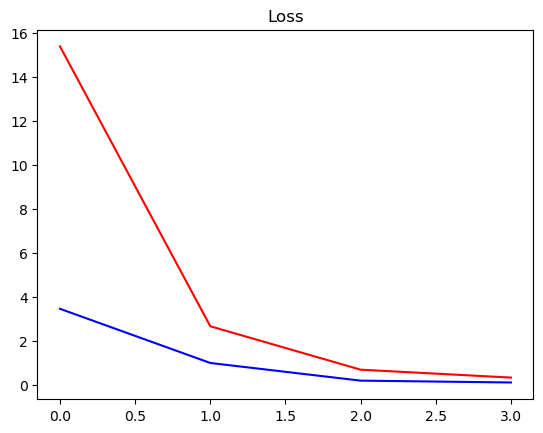

In [228]:
# plot loss
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

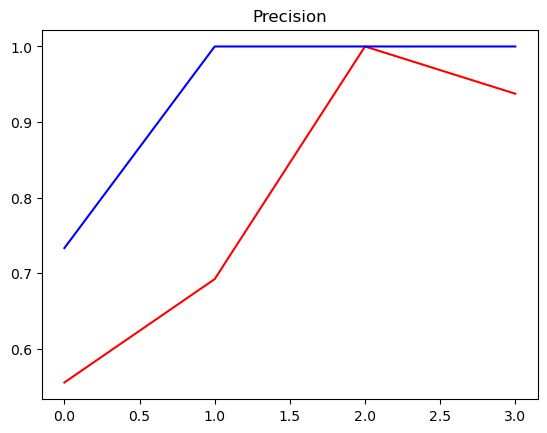

In [229]:
# plot precision
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

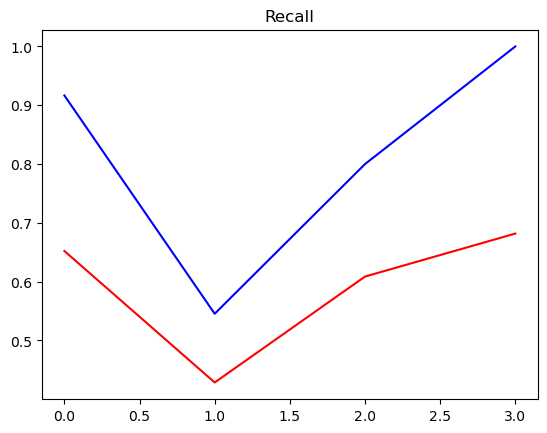

In [230]:
# plot recall
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# Make a Prediction on a Single Clip

In [317]:
# get one batch and make a prediction
X_test, y_test = test.as_numpy_iterator().next()

In [318]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 103ms/step


In [319]:
yhat

array([[0.920885  ],
       [0.38942653],
       [0.00170805],
       [0.00179715]], dtype=float32)

In [320]:
# Convert logits to classes
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [321]:
yhat

[1, 0, 0, 0]

In [322]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [323]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

In [324]:
y_test.astype(int)

array([1, 1, 0, 0])